In [1]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
iamsouravbanerjee_animal_image_dataset_90_different_animals_path = kagglehub.dataset_download('iamsouravbanerjee/animal-image-dataset-90-different-animals')

print('Data source import complete.')


Data source import complete.


# Step 1: Import Libraries

In [2]:
import warnings
warnings.filterwarnings('ignore')

# Importing necessary libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import plotly.graph_objects as go
import plotly.express as px

# Step 2: Load and Preprocess Data

In [3]:
# # Paths to the dataset
# dataset_path = "/Kuliah/Sem 7/PCD/Tubes/animals/animals"
# labels_file = "/Kuliah/Sem 7/PCD/Tubes/animals/name of the animals.txt"
dataset_path = "/root/.cache/kagglehub/datasets/iamsouravbanerjee/animal-image-dataset-90-different-animals/versions/5/animals/animals"
labels_file = "/root/.cache/kagglehub/datasets/iamsouravbanerjee/animal-image-dataset-90-different-animals/versions/5/name of the animals.txt"

In [4]:
# Reading labels
with open(labels_file, 'r') as f:
    animal_names = f.read().split('\n')

In [5]:
# Display the first few animal names
animal_names[:10]

['antelope',
 'badger',
 'bat',
 'bear',
 'bee',
 'beetle',
 'bison',
 'boar',
 'butterfly',
 'cat']

# Explotratory data analysis

In [6]:
# Display distribution of animal classes
animal_counts = {animal: len(os.listdir(os.path.join(dataset_path, animal))) for animal in animal_names}
animal_counts_df = pd.DataFrame(list(animal_counts.items()), columns=['Animal', 'Count'])
animal_counts_df = animal_counts_df.sort_values(by='Count', ascending=False)

fig = px.bar(animal_counts_df, x='Animal', y='Count', title='Distribution of Animal Classes',
             labels={'Animal': 'Animal', 'Count': 'Number of Images'},
             color='Count', color_continuous_scale='Viridis', template='plotly_dark')
fig.update_layout(title_font_size=24, title_x=0.5, xaxis_title_font_size=18,
                 yaxis_title_font_size=18, font=dict(family="Arial, sans-serif", size=14))
fig.show()

In [7]:
class AnimalDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

In [8]:
# Image Preprocessing using OpenCV
def preprocess_image(image_path):
    image = cv2.imread(image_path)
    image = cv2.resize(image, (224, 224))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = (image / 255.0).astype(np.float32)
    return image

In [9]:
# Create dataset
data = []
labels = []

for animal in animal_names:
    animal_dir = os.path.join(dataset_path, animal)
    for img_name in os.listdir(animal_dir):
        img_path = os.path.join(animal_dir, img_name)
        data.append(preprocess_image(img_path))
        labels.append(animal)

data = np.array(data)
labels = np.array(labels)

In [10]:
# Encode labels
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels)

In [11]:
#Model Definition
import torchvision.models as models

class AnimalClassifier(nn.Module):
    def __init__(self, num_classes, pretrained=True):
        super(AnimalClassifier, self).__init__()
        # Gunakan model yang lebih besar
        self.resnet = models.resnet101(weights='IMAGENET1K_V2' if pretrained else None)

        # Freeze fewer layers
        for param in list(self.resnet.parameters())[:-20]:  # Freeze fewer layers
            param.requires_grad = False

        num_ftrs = self.resnet.fc.in_features

        # Tambahkan dropout dan layer tambahan
        self.resnet.fc = nn.Sequential(
            nn.Linear(num_ftrs, 1024),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        return self.resnet(x)

In [12]:
# Data Preparation
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

In [13]:
# Data transformations
IMAGE_SIZE = 160

from torchvision.transforms import RandomAffine, ColorJitter, RandomPerspective

# Training transforms
train_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.2),
    transforms.RandomRotation(30),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomAffine(degrees=0, translate=(0.2, 0.2), scale=(0.8, 1.2)),
    transforms.RandomPerspective(distortion_scale=0.2, p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


# Test transforms
test_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [14]:
# Create datasets with the corrected transform
train_dataset = AnimalDataset(X_train, y_train, train_transform)
test_dataset = AnimalDataset(X_test, y_test, test_transform)

# Performance optimizations
torch.backends.cudnn.benchmark = True
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True

# Modify your data loaders for better performance
train_loader = DataLoader(
    train_dataset,
    batch_size=64,
    shuffle=True,
    num_workers=4,
    pin_memory=True,
    persistent_workers=True,
    prefetch_factor=2
)

test_loader = DataLoader(
    test_dataset,
    batch_size=64,
    shuffle=False,
    num_workers=4,
    pin_memory=True,
    persistent_workers=True,
    prefetch_factor=2
)

In [15]:
# Model Training
from torch.cuda.amp import autocast, GradScaler
from tqdm.auto import tqdm
# Initialize model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AnimalClassifier(num_classes=len(animal_names)).to(device)

# Mixed precision training setup
scaler = GradScaler()

In [16]:
# Training loop
num_epochs = 30
best_acc = 0.0

In [17]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = optim.AdamW(model.parameters(), lr=0.0003, weight_decay=0.05)

# Learning rate scheduler
scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer,
    T_0=5,
    T_mult=2,
    eta_min=1e-6
)

In [18]:
def train_epoch(model, train_loader, criterion, optimizer, scheduler, device, scaler):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    # Use tqdm for progress tracking
    progress_bar = tqdm(train_loader, desc='Training')

    for batch_idx, (images, labels) in enumerate(progress_bar):
        images = images.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)

        # Zero gradients for every batch
        optimizer.zero_grad(set_to_none=True)

        # Automatic mixed precision training
        with autocast():
            outputs = model(images)
            loss = criterion(outputs, labels)

        # Scale loss and compute gradients
        scaler.scale(loss).backward()

        # Unscale gradients and clip
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        # Optimizer step
        scaler.step(optimizer)
        scaler.update()

        # Learning rate scheduling
        scheduler.step()

        # Compute accuracy
        with torch.no_grad():
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        # Update running loss
        running_loss += loss.item()

        # Update progress bar
        acc = 100. * correct / total
        progress_bar.set_postfix({
            'loss': f'{running_loss/(batch_idx+1):.3f}',
            'acc': f'{acc:.2f}%'
        })

    return running_loss / len(train_loader), 100. * correct / total

@torch.no_grad()
def validate(model, val_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    progress_bar = tqdm(val_loader, desc='Validating')

    for images, labels in progress_bar:
        images = images.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)

        with autocast():
            outputs = model(images)
            loss = criterion(outputs, labels)

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

        # Update progress bar
        acc = 100. * correct / total
        progress_bar.set_postfix({
            'loss': f'{running_loss/(total/labels.size(0)):.3f}',
            'acc': f'{acc:.2f}%'
        })

    return running_loss / len(val_loader), 100. * correct / total

Starting training...


Training:   0%|          | 0/68 [00:00<?, ?it/s]

Validating:   0%|          | 0/17 [00:00<?, ?it/s]


Epoch [1/30]
Train Loss: 4.2294, Train Acc: 12.22%
Val Loss: 3.4221, Val Acc: 53.24%
New best model saved with validation accuracy: 53.24%


Training:   0%|          | 0/68 [00:00<?, ?it/s]

Validating:   0%|          | 0/17 [00:00<?, ?it/s]


Epoch [2/30]
Train Loss: 2.7949, Train Acc: 47.38%
Val Loss: 1.6145, Val Acc: 77.41%
New best model saved with validation accuracy: 77.41%


Training:   0%|          | 0/68 [00:00<?, ?it/s]

Validating:   0%|          | 0/17 [00:00<?, ?it/s]


Epoch [3/30]
Train Loss: 1.9565, Train Acc: 65.60%
Val Loss: 1.3575, Val Acc: 81.76%
New best model saved with validation accuracy: 81.76%


Training:   0%|          | 0/68 [00:00<?, ?it/s]

Validating:   0%|          | 0/17 [00:00<?, ?it/s]


Epoch [4/30]
Train Loss: 1.5772, Train Acc: 76.78%
Val Loss: 1.1838, Val Acc: 88.61%
New best model saved with validation accuracy: 88.61%


Training:   0%|          | 0/68 [00:00<?, ?it/s]

Validating:   0%|          | 0/17 [00:00<?, ?it/s]


Epoch [5/30]
Train Loss: 1.4364, Train Acc: 80.88%
Val Loss: 1.2229, Val Acc: 87.13%


Training:   0%|          | 0/68 [00:00<?, ?it/s]

Validating:   0%|          | 0/17 [00:00<?, ?it/s]


Epoch [6/30]
Train Loss: 1.4602, Train Acc: 80.09%
Val Loss: 1.2225, Val Acc: 88.33%


Training:   0%|          | 0/68 [00:00<?, ?it/s]

Validating:   0%|          | 0/17 [00:00<?, ?it/s]


Epoch [7/30]
Train Loss: 1.3281, Train Acc: 84.72%
Val Loss: 1.1011, Val Acc: 90.93%
New best model saved with validation accuracy: 90.93%


Training:   0%|          | 0/68 [00:00<?, ?it/s]

Validating:   0%|          | 0/17 [00:00<?, ?it/s]


Epoch [8/30]
Train Loss: 1.2349, Train Acc: 87.48%
Val Loss: 1.0706, Val Acc: 92.69%
New best model saved with validation accuracy: 92.69%


Training:   0%|          | 0/68 [00:00<?, ?it/s]

Validating:   0%|          | 0/17 [00:00<?, ?it/s]


Epoch [9/30]
Train Loss: 1.1690, Train Acc: 89.56%
Val Loss: 1.0597, Val Acc: 93.24%
New best model saved with validation accuracy: 93.24%


Training:   0%|          | 0/68 [00:00<?, ?it/s]

Validating:   0%|          | 0/17 [00:00<?, ?it/s]


Epoch [10/30]
Train Loss: 1.2057, Train Acc: 88.54%
Val Loss: 1.1404, Val Acc: 91.39%


Training:   0%|          | 0/68 [00:00<?, ?it/s]

Validating:   0%|          | 0/17 [00:00<?, ?it/s]


Epoch [11/30]
Train Loss: 1.2455, Train Acc: 86.85%
Val Loss: 1.1870, Val Acc: 90.09%


Training:   0%|          | 0/68 [00:00<?, ?it/s]

Validating:   0%|          | 0/17 [00:00<?, ?it/s]


Epoch [12/30]
Train Loss: 1.1879, Train Acc: 89.35%
Val Loss: 1.1002, Val Acc: 92.13%


Training:   0%|          | 0/68 [00:00<?, ?it/s]

Validating:   0%|          | 0/17 [00:00<?, ?it/s]


Epoch [13/30]
Train Loss: 1.1589, Train Acc: 90.16%
Val Loss: 1.0658, Val Acc: 92.41%


Training:   0%|          | 0/68 [00:00<?, ?it/s]

Validating:   0%|          | 0/17 [00:00<?, ?it/s]


Epoch [14/30]
Train Loss: 1.1114, Train Acc: 91.67%
Val Loss: 1.0581, Val Acc: 92.69%


Training:   0%|          | 0/68 [00:00<?, ?it/s]

Validating:   0%|          | 0/17 [00:00<?, ?it/s]


Epoch [15/30]
Train Loss: 1.0572, Train Acc: 93.26%
Val Loss: 1.0692, Val Acc: 92.96%


Training:   0%|          | 0/68 [00:00<?, ?it/s]

Validating:   0%|          | 0/17 [00:00<?, ?it/s]


Epoch [16/30]
Train Loss: 1.0350, Train Acc: 93.84%
Val Loss: 1.0588, Val Acc: 93.24%


Training:   0%|          | 0/68 [00:00<?, ?it/s]

Validating:   0%|          | 0/17 [00:00<?, ?it/s]


Epoch [17/30]
Train Loss: 1.0031, Train Acc: 94.77%
Val Loss: 1.0281, Val Acc: 93.43%
New best model saved with validation accuracy: 93.43%


Training:   0%|          | 0/68 [00:00<?, ?it/s]

Validating:   0%|          | 0/17 [00:00<?, ?it/s]


Epoch [18/30]
Train Loss: 0.9862, Train Acc: 95.58%
Val Loss: 1.0324, Val Acc: 92.87%


Training:   0%|          | 0/68 [00:00<?, ?it/s]

Validating:   0%|          | 0/17 [00:00<?, ?it/s]


Epoch [19/30]
Train Loss: 1.0132, Train Acc: 94.24%
Val Loss: 1.0645, Val Acc: 92.78%


Training:   0%|          | 0/68 [00:00<?, ?it/s]

Validating:   0%|          | 0/17 [00:00<?, ?it/s]


Epoch [20/30]
Train Loss: 1.0817, Train Acc: 92.66%
Val Loss: 1.1239, Val Acc: 91.30%


Training:   0%|          | 0/68 [00:00<?, ?it/s]

Validating:   0%|          | 0/17 [00:00<?, ?it/s]


Epoch [21/30]
Train Loss: 1.0845, Train Acc: 92.66%
Val Loss: 1.0888, Val Acc: 92.41%


Training:   0%|          | 0/68 [00:00<?, ?it/s]

Validating:   0%|          | 0/17 [00:00<?, ?it/s]


Epoch [22/30]
Train Loss: 1.0720, Train Acc: 92.55%
Val Loss: 1.0877, Val Acc: 92.22%


Training:   0%|          | 0/68 [00:00<?, ?it/s]

Validating:   0%|          | 0/17 [00:00<?, ?it/s]


Epoch [23/30]
Train Loss: 1.0521, Train Acc: 93.22%
Val Loss: 1.1177, Val Acc: 91.85%


Training:   0%|          | 0/68 [00:00<?, ?it/s]

Validating:   0%|          | 0/17 [00:00<?, ?it/s]


Epoch [24/30]
Train Loss: 1.0590, Train Acc: 93.06%
Val Loss: 1.1168, Val Acc: 91.57%


Training:   0%|          | 0/68 [00:00<?, ?it/s]

Validating:   0%|          | 0/17 [00:00<?, ?it/s]


Epoch [25/30]
Train Loss: 1.0346, Train Acc: 94.07%
Val Loss: 1.0506, Val Acc: 92.69%


Training:   0%|          | 0/68 [00:00<?, ?it/s]

Validating:   0%|          | 0/17 [00:00<?, ?it/s]


Epoch [26/30]
Train Loss: 0.9929, Train Acc: 95.32%
Val Loss: 1.0347, Val Acc: 92.87%


Training:   0%|          | 0/68 [00:00<?, ?it/s]

Validating:   0%|          | 0/17 [00:00<?, ?it/s]


Epoch [27/30]
Train Loss: 0.9902, Train Acc: 95.28%
Val Loss: 1.0721, Val Acc: 92.22%

Early stopping triggered after 27 epochs
Training completed!


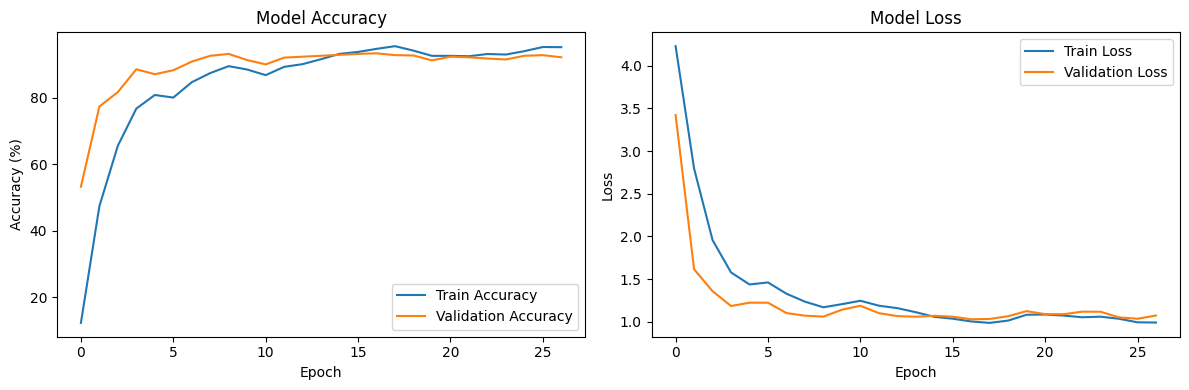

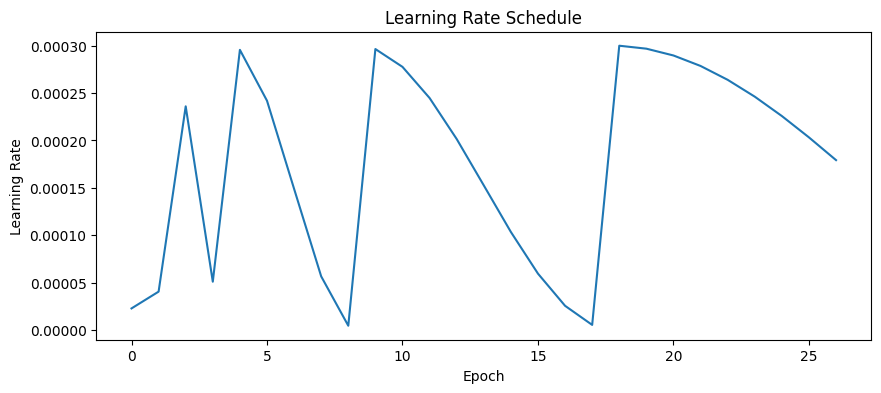

In [19]:
# Initialize early stopping parameters
early_stopping_patience = 10
early_stopping_counter = 0
best_val_acc = 0

# Training history
history = {
    'train_loss': [], 'train_acc': [],
    'val_loss': [], 'val_acc': [],
    'lr': []
}

# Training loop
print("Starting training...")

# Training loop
for epoch in range(num_epochs):
    # Training phase
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, scheduler, device, scaler)

    # Validation phase
    val_loss, val_acc = validate(model, test_loader, criterion, device)

    # Print results
    print(f'\nEpoch [{epoch+1}/{num_epochs}]')
    print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%')
    print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')

    # Get current learning rate
    current_lr = optimizer.param_groups[0]['lr']

    # Save history
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    history['lr'].append(current_lr)

    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        early_stopping_counter = 0
        print(f'New best model saved with validation accuracy: {val_acc:.2f}%')
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'best_val_acc': best_val_acc,
            'history': history
        }, 'best_model.pth')
    else:
        early_stopping_counter += 1

    # Early stopping
    if early_stopping_counter >= early_stopping_patience:
        print(f'\nEarly stopping triggered after {epoch+1} epochs')
        break

print("Training completed!")

# Plot training history
plt.figure(figsize=(12, 4))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history['train_acc'], label='Train Accuracy')
plt.plot(history['val_acc'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Model Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Model Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Plot learning rate
plt.figure(figsize=(10, 4))
plt.plot(history['lr'])
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.title('Learning Rate Schedule')
plt.show()

In [20]:
# Model Evaluation
# Plot training history
fig = go.Figure()
fig.add_trace(go.Scatter(x=list(range(1, num_epochs+1)), y=history['train_acc'],
                        mode='lines+markers', name='Training Accuracy'))
fig.add_trace(go.Scatter(x=list(range(1, num_epochs+1)), y=history['val_acc'],
                        mode='lines+markers', name='Validation Accuracy'))
fig.update_layout(title='Model Accuracy', xaxis_title='Epoch', yaxis_title='Accuracy',
                 title_font_size=24, title_x=0.5, xaxis_title_font_size=18,
                 yaxis_title_font_size=18, font=dict(family="Arial, sans-serif", size=14),
                 template='plotly_dark')
fig.show()


Evaluating best model...

Classification Report:
                precision    recall  f1-score   support

      antelope       0.85      1.00      0.92        11
        badger       1.00      1.00      1.00        19
           bat       1.00      0.91      0.95        11
          bear       1.00      0.92      0.96        13
           bee       1.00      0.88      0.93        16
        beetle       1.00      1.00      1.00        11
         bison       0.92      1.00      0.96        12
          boar       0.93      0.88      0.90        16
     butterfly       1.00      0.83      0.91        12
           cat       1.00      1.00      1.00        13
   caterpillar       0.85      1.00      0.92        11
    chimpanzee       1.00      1.00      1.00        12
     cockroach       1.00      1.00      1.00        15
           cow       0.91      0.67      0.77        15
        coyote       1.00      1.00      1.00        11
          crab       1.00      1.00      1.00        

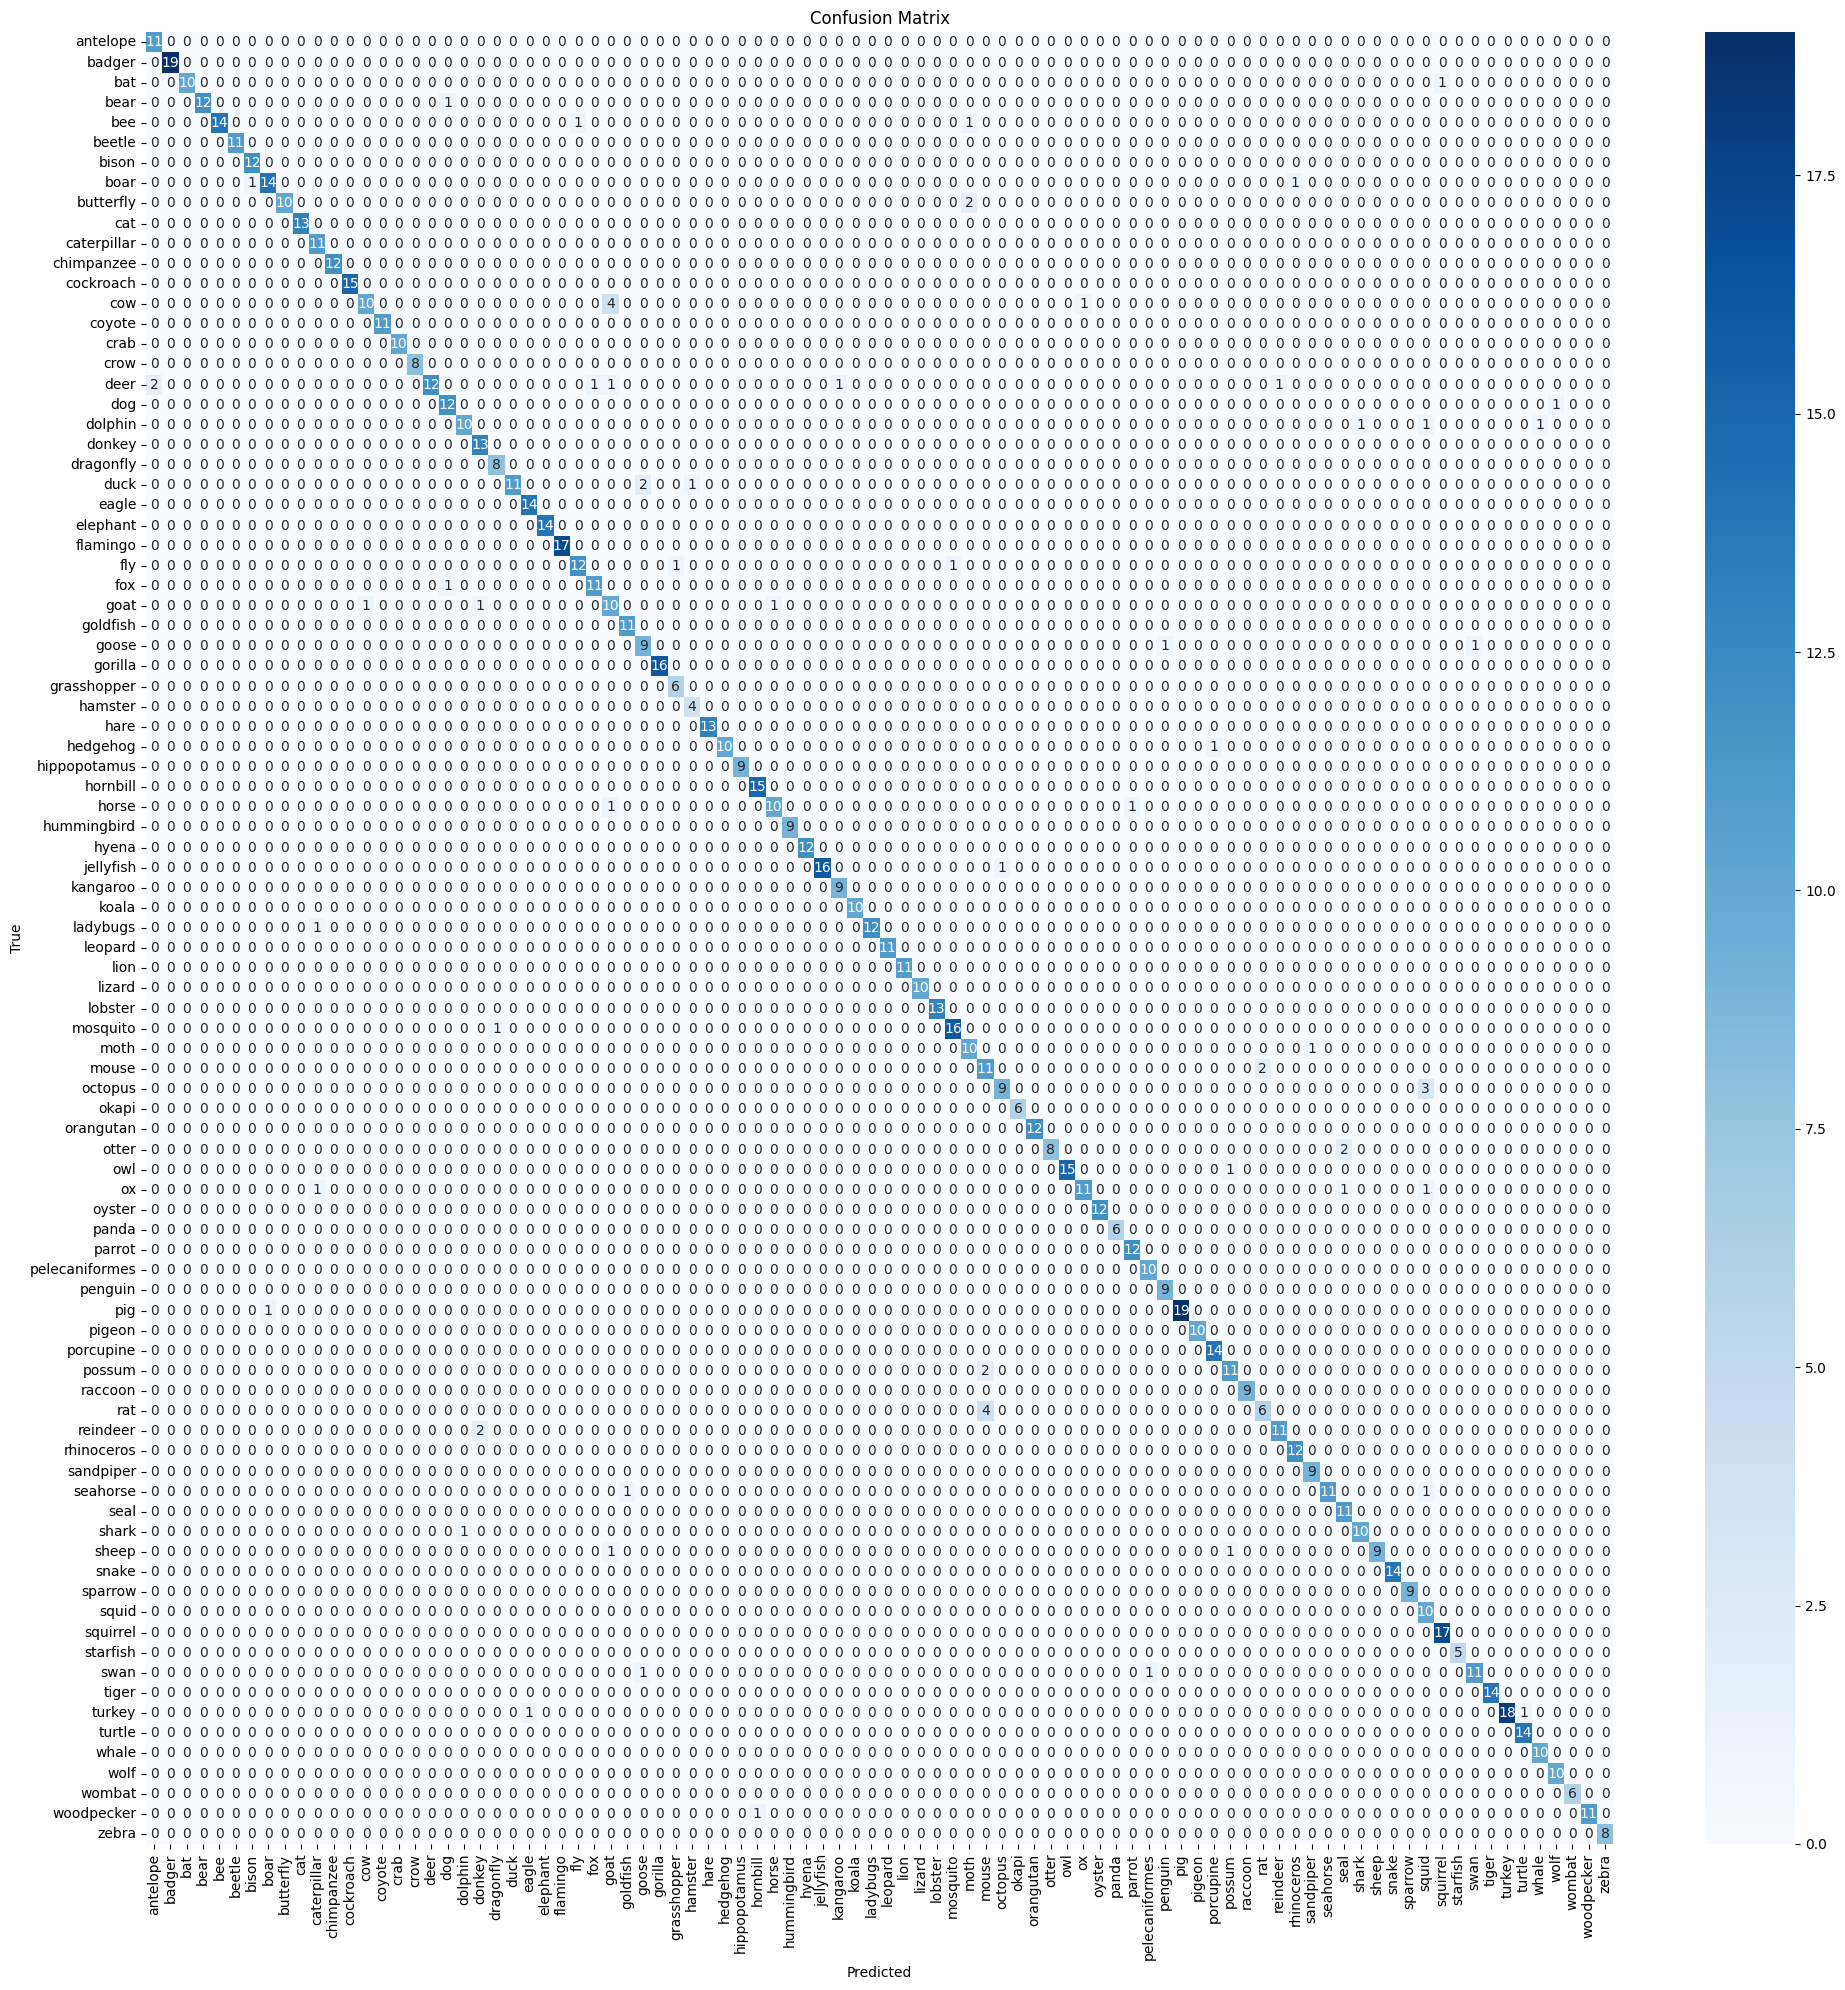

In [21]:
# Load best model and evaluate
print("\nEvaluating best model...")
checkpoint = torch.load('best_model.pth')
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = outputs.max(1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Print classification report
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=label_encoder.classes_))

# Create confusion matrix visualization
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(20, 20))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

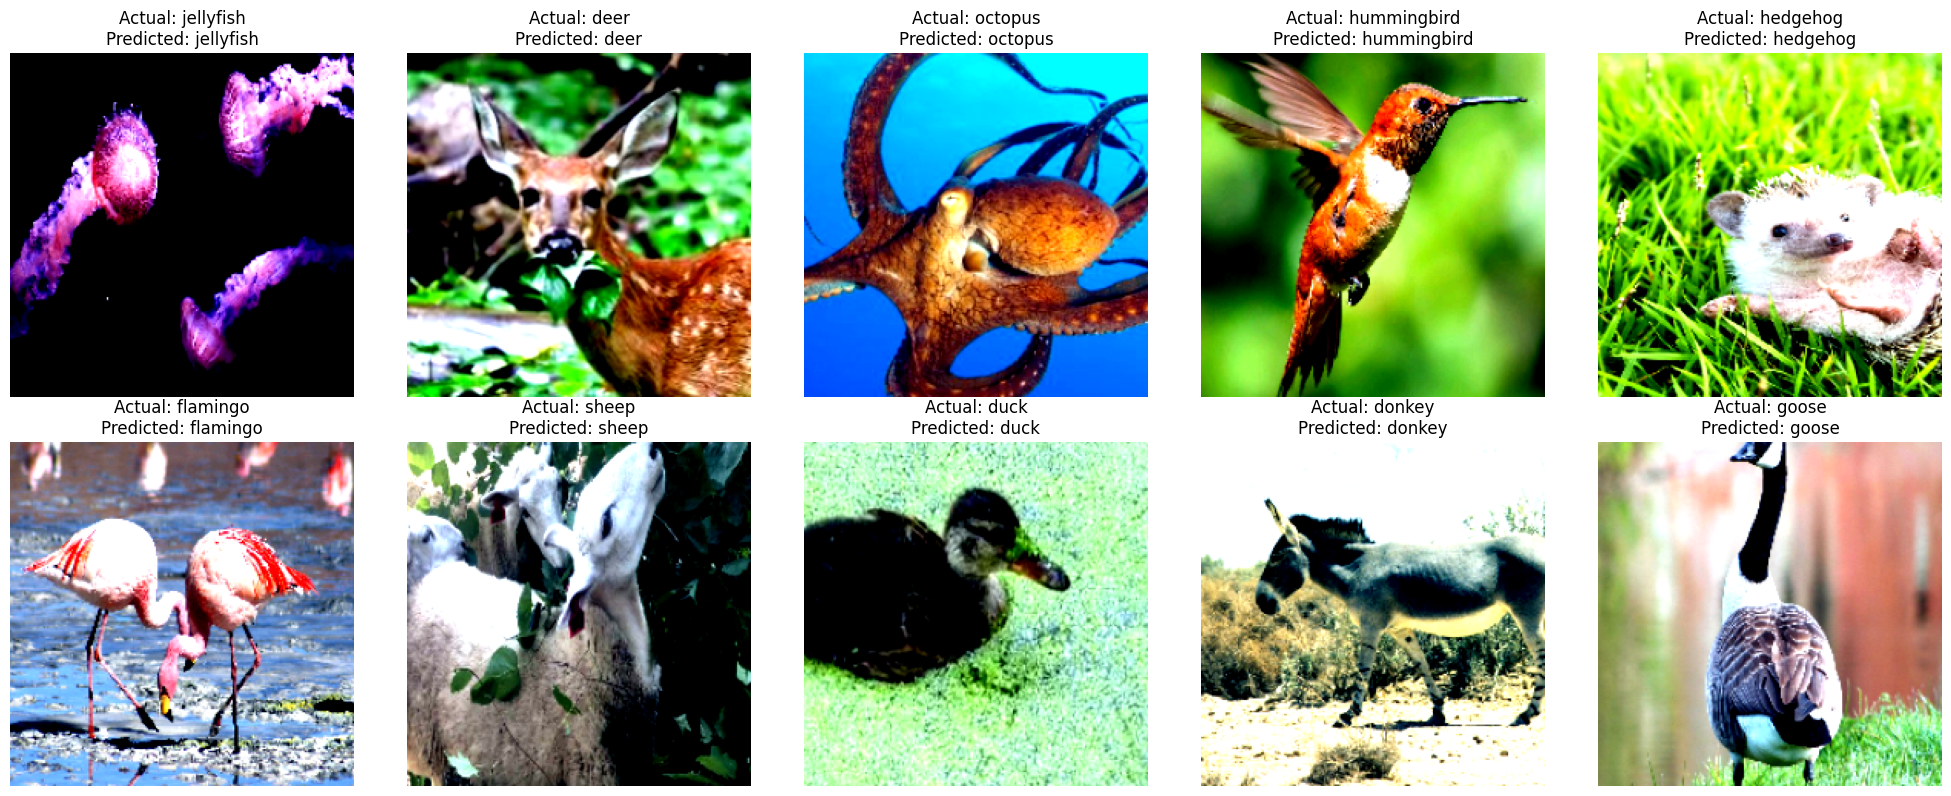

In [22]:
# Sample Predictions
def display_predictions(model, test_loader, num_samples=10):
    model.eval()
    images, labels = next(iter(test_loader))
    images = images[:num_samples]
    labels = labels[:num_samples]

    with torch.no_grad():
        outputs = model(images.to(device))
        _, predicted = outputs.max(1)

    fig, axes = plt.subplots(2, 5, figsize=(20, 8))
    axes = axes.flatten()

    for i, ax in enumerate(axes):
        img = images[i].permute(1, 2, 0).cpu().numpy()
        img = (img * 0.5 + 0.5).clip(0, 1)
        ax.imshow(img)
        ax.axis('off')
        true_label = label_encoder.inverse_transform([labels[i].item()])[0]
        pred_label = label_encoder.inverse_transform([predicted[i].item()])[0]
        ax.set_title(f'Actual: {true_label}\nPredicted: {pred_label}')

    plt.tight_layout()
    plt.show()

display_predictions(model, test_loader)